<Body>   
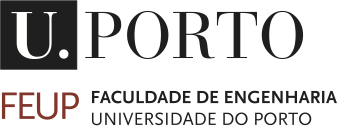   
<h1> <b>Swarm Robotics Competitions 2022/2023 </b> </h1>
</Body>  

**A. Pedro Aguiar** (pedro.aguiar@fe.up.pt)

FEUP, Oct. 2022

---


# 6 - Obstacle avoidance


### **Single agent case**


Consider a single agent (robot)

$$ 
\begin{align}
\dot x = u
\end{align}
$$

where 
$$
x = 
\begin{bmatrix} 
x_{1} \\
x_{2}
\end{bmatrix} \,, \quad
u = 
\begin{bmatrix} 
u_{1} \\
u_{2} 
\end{bmatrix}
$$

are the 2D state and 2D control, respectively.



Let's now assume that there is a circular shaped obstacle (green) centered at  [1.0, 1.0] with radius $r=0.5\,m$ between the robot initial position (black) at the origin  [0.0, 0.0]  and the desired goal (blue) at  [1.5, 2.0].

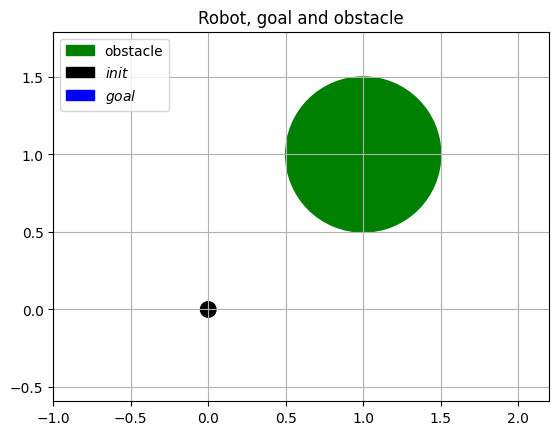

In [45]:
import matplotlib.pyplot as plt

circle = plt.Circle((1.0, 1.0), 0.5, color='g', label='obstacle')
robot = plt.Circle((0.0, 0.0), 0.05, color='k', label='$init$')
goal = plt.Circle((1.5, 2.0), 0.05, color='b', label='$goal$')

fig, ax = plt.subplots()

ax.axis('equal')
plt.xlim(-1,2.2)
plt.ylim(-1,2.2)
plt.grid()
plt.title('Robot, goal and obstacle');
ax.add_patch(circle);
ax.add_patch(robot);
ax.add_patch(goal);
plt.legend(loc='best');

We propose a small modification on the previous controller by introducing an extra *repulsive term* as follows

$$
u = - K \tilde x + \frac{k_o}{d^2} ( x - x_o ) + \dot{x}_d \,, \quad d = ||x - x_o ||-r
$$

where $k_o$ is a positive gain, and $x_o = [1.0, 1.0]$ and $r$ are the center position of the obstacle and radius, respectively. Notice that $d$ is the distance between the robot position and the obstacle boundary.

In this case, the closed-loop tracking error satisfies:

$$
\dot {\tilde x} + K \tilde x = \frac{k_o}{d^2} ( x - x_o )\,, \quad K > 0
$$
Note that the new term can be interpreted as a repulsive field around the obstacle, as shown by the simulations below.





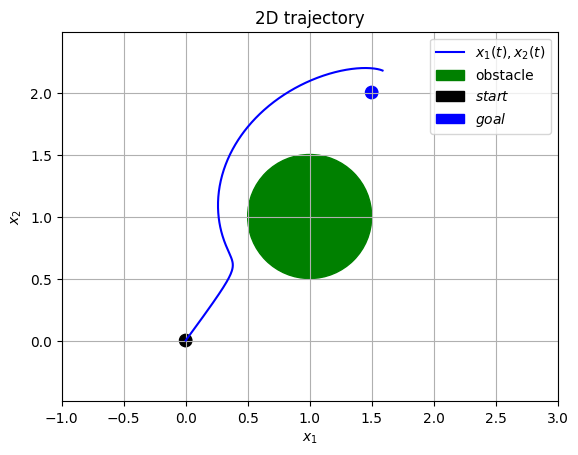

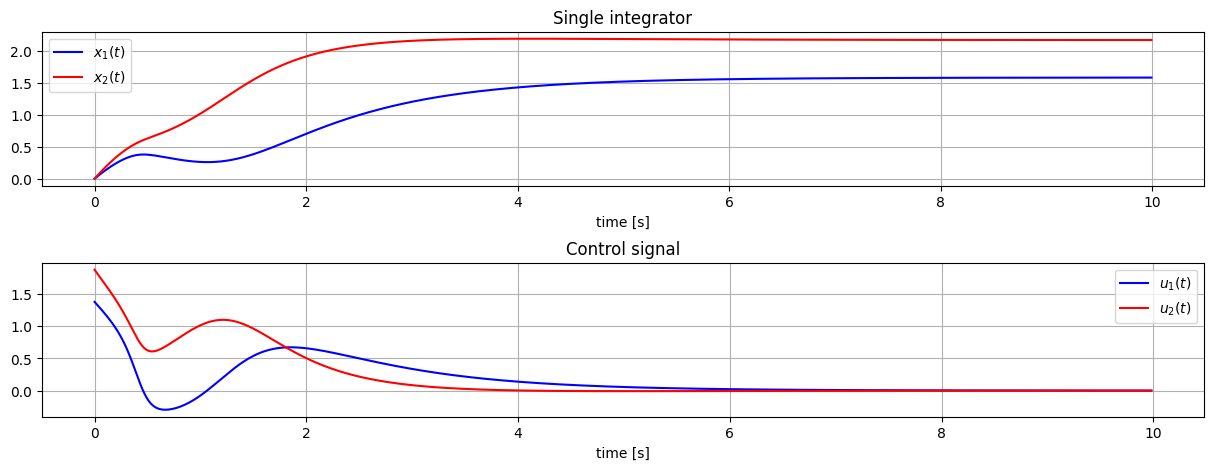

In [46]:
import numpy as np
import matplotlib.pyplot as plt


def step_f(x,u,h):
  return x + u*h

h = 0.01 # This is my sampling time
t_end=10 # This is my final time of the simulation

t_signal = np.arange(0,t_end,h) # time samples
x_signal = np.zeros_like([t_signal,t_signal])
u_signal = np.zeros_like([t_signal,t_signal])

# Reference signals
xd_signal= np.zeros_like(x_signal)
xd_signal[0] = 1.5*np.ones(t_signal.shape[0])
xd_signal[1]= 2.0*np.ones(t_signal.shape[0])
#xd_signal[0]= 1.5*np.ones(x_signal)
#xd_signal[1]= 2.0*np.ones(x_signal)
xd_dot_signal= np.zeros_like(x_signal)
# xd_dot_signal[0]= np.cos(t_signal)
# xd_dot_signal[1]= -np.sin(t_signal)

# Gain matrix
k1, k2 = 1, 1
K = np.diag([k1,k2])
Ko = 0.1*K
radius = 0.5
xo = np.array([ 1.0, 1.0 ])

#Initial conditions of our system
x_signal[:,0]=[0,0]


# Iteration
for i in range(0,t_signal.shape[0]-1):
  #control law
  distance = np.linalg.norm(x_signal[:,i] - xo) - radius
  u_signal[:,i] = - K @(x_signal[:,i]-xd_signal[:,i]) \
  + (1/distance**2)*Ko @ ( x_signal[:,i] - xo ) + xd_dot_signal[:,i]
  x_signal[:,i+1] = step_f(x_signal[:,i],u_signal[:,i],h)

#plot
circle = plt.Circle((1.0, 1.0), 0.5, color='g', label='obstacle')
robot = plt.Circle((0.0, 0.0), 0.05, color='k', label='$start$')
goal = plt.Circle((1.5, 2.0), 0.05, color='b', label='$goal$')
fig, ax = plt.subplots()
ax.axis('equal')
plt.xlim(-1,3.0)
plt.ylim(-1,3.0)
plt.plot(x_signal[0], x_signal[1], label='$x_1(t), x_2(t)$', color='b')
#plt.plot(xd_signal[0], xd_signal[1], label='$x_{d1}(t), x_{d2}(t)$', color='r', linestyle='dashed')
plt.xlabel('$x_1 [m]$');
plt.ylabel('$x_2 [m]$');
plt.title('2D trajectory');
plt.grid()
ax.add_patch(circle);
ax.add_patch(robot);
ax.add_patch(goal);
plt.xlabel('$x_1$');
plt.ylabel('$x_2$');
plt.title('2D trajectory');
plt.legend(loc='best');

fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(t_signal, x_signal[0], 'b-', label='$x_1(t)$')
ax1.plot(t_signal, x_signal[1], 'r-', label='$x_2(t)$')
ax1.set_title("Single integrator")
ax1.set_xlabel("time [s]")
ax1.grid()
ax1.legend(loc='best')

ax2.plot(t_signal[0:len(t_signal)-1], u_signal[0,0:len(t_signal)-1], 'b-', label='$u_1(t)$')
ax2.plot(t_signal[0:len(t_signal)-1], u_signal[1,0:len(t_signal)-1], 'r-', label='$u_2(t)$')
#ax2.set_ylim((0, 1.2))
ax2.set_title("Control signal")
ax2.set_xlabel("time [s]")
ax2.grid()
ax2.legend(loc='best')


To decrease the influence of the repulsive term when the robot is not close to the obstacle, we now consider the case where the gain $k_o$ is a function that changes with the distance from the obstacle, according to

$$
k_o(d) = \bar k_o e^{-c d^2}
$$

where $\bar k_o, c$ are some positive constants.

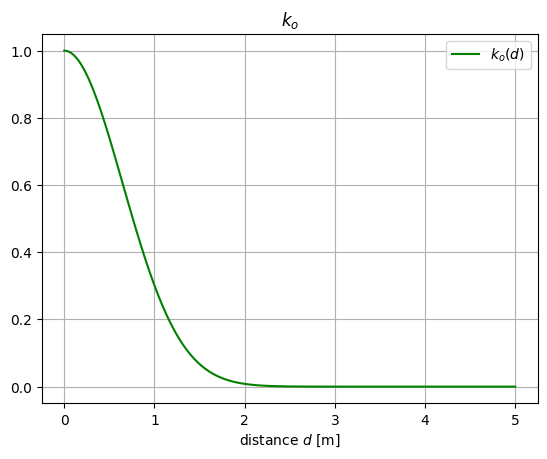

In [47]:
distance = np.linspace(0, 5, 1000)
ko_list = np.zeros(len(distance))

c = 1.2
for k in range(len(distance)):
    ko_list[k] = np.exp(- c*distance[k]**2)

plt.figure()
plt.plot(distance, ko_list, label='$k_o(d)$', color='g')

plt.xlabel('distance $d$ [m]');
plt.legend()
plt.grid()
plt.title('$k_o$');

In this way, we can decrease significantly the trajectory offset, as shown in the simulations below.

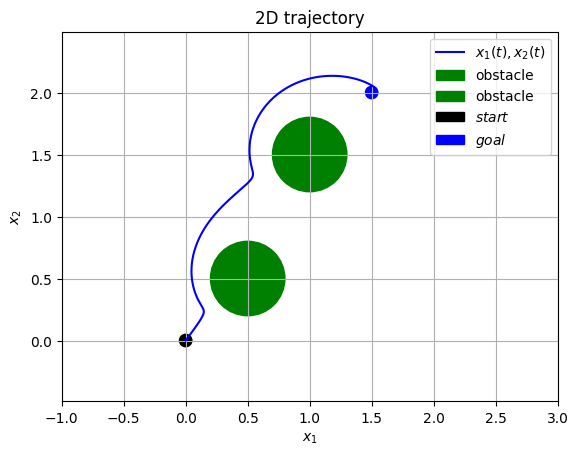

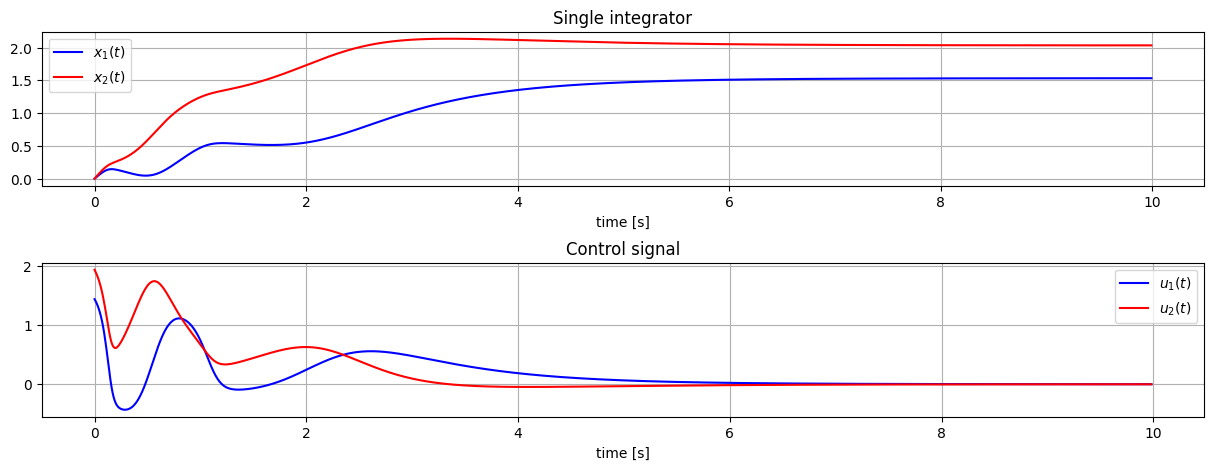

In [48]:
import numpy as np
import matplotlib.pyplot as plt


def step_f(x,u,h):
  return x + u*h

h = 0.01 # This is my sampling time
t_end=10 # This is my final time of the simulation

t_signal = np.arange(0,t_end,h) # time samples
x_signal = np.zeros_like([t_signal,t_signal])
u_signal = np.zeros_like([t_signal,t_signal])

# Reference signals
xd_signal= np.zeros_like(x_signal)
xd_signal[0] = 1.5*np.ones(t_signal.shape[0])
xd_signal[1]= 2.0*np.ones(t_signal.shape[0])
#xd_signal[0]= 1.5*np.ones(x_signal)
#xd_signal[1]= 2.0*np.ones(x_signal)
xd_dot_signal= np.zeros_like(x_signal)
# xd_dot_signal[0]= np.cos(t_signal)
# xd_dot_signal[1]= -np.sin(t_signal)

# Parameters values
k1, k2 = 1, 1
K = np.diag([k1,k2])
Ko_init = 0.1*K
c = 10

# Obstacles
xo1 = np.array([0.5, 0.5])
xo2 = np.array([1.0, 1.5])
radius = 0.3

#Initial conditions of our system
x_signal[:,0]=[0,0]


# Iteration
for i in range(0,t_signal.shape[0]-1):
  #control law
  distance1 = np.linalg.norm(x_signal[:,i] - xo1) - radius
  ko1 = np.exp(-c*distance1**2)
  Ko1 = ko1*Ko_init

  distance2 = np.linalg.norm(x_signal[:,i] - xo2) - radius
  ko2 = np.exp(-c*distance2**2)
  Ko2 = ko2*Ko_init

  u_signal[:,i] = - K @(x_signal[:,i]-xd_signal[:,i]) \
  + (1/distance1**2)*Ko1 @ ( x_signal[:,i] - xo1 ) + xd_dot_signal[:,i] \
  + (1/distance2**2)*Ko2 @ ( x_signal[:,i] - xo2 ) + xd_dot_signal[:,i]
  x_signal[:,i+1] = step_f(x_signal[:,i],u_signal[:,i],h)

#plot
circle1 = plt.Circle((0.5, 0.5), 0.3, color='g', label='obstacle')
circle2 = plt.Circle((1.0, 1.5), 0.3, color='g', label='obstacle')
robot = plt.Circle((0.0, 0.0), 0.05, color='k', label='$start$')
goal = plt.Circle((1.5, 2.0), 0.05, color='b', label='$goal$')
fig, ax = plt.subplots()
ax.axis('equal')
plt.xlim(-1,3.0)
plt.ylim(-1,3.0)
plt.plot(x_signal[0], x_signal[1], label='$x_1(t), x_2(t)$', color='b')
#plt.plot(xd_signal[0], xd_signal[1], label='$x_{d1}(t), x_{d2}(t)$', color='r', linestyle='dashed')
plt.xlabel('$x_1 [m]$');
plt.ylabel('$x_2 [m]$');
plt.title('2D trajectory');
plt.grid()
ax.add_patch(circle1);
ax.add_patch(circle2);
ax.add_patch(robot);
ax.add_patch(goal);
plt.xlabel('$x_1$');
plt.ylabel('$x_2$');
plt.title('2D trajectory');
plt.legend(loc='best');

fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(t_signal, x_signal[0], 'b-', label='$x_1(t)$')
ax1.plot(t_signal, x_signal[1], 'r-', label='$x_2(t)$')
ax1.set_title("Single integrator")
ax1.set_xlabel("time [s]")
ax1.grid()
ax1.legend(loc='best')

ax2.plot(t_signal[0:len(t_signal)-1], u_signal[0,0:len(t_signal)-1], 'b-', label='$u_1(t)$')
ax2.plot(t_signal[0:len(t_signal)-1], u_signal[1,0:len(t_signal)-1], 'r-', label='$u_2(t)$')
#ax2.set_ylim((0, 1.2))
ax2.set_title("Control signal")
ax2.set_xlabel("time [s]")
ax2.grid()
ax2.legend(loc='best')


**Activity 1.** Go above and try:

1. Other position goals $x_d$, and different obstacles positions
2. More than one obstacle


### **Obstacle and collision avoidance in the case of multiple agents following a leader**


Consider a fleet of n=5 agents (robots), where each agent satisfies the following dynamics

$$ 
\begin{align}
\dot x_i = u_i, \quad i =1, 2, \ldots n
\end{align}
$$

where 
$$
x_i = 
\begin{bmatrix} 
x_{1i} \\
x_{2i}
\end{bmatrix} \,, \quad
u_i = 
\begin{bmatrix} 
u_{1i} \\
u_{2i} 
\end{bmatrix}
$$

are the 2D state and 2D control for each agent $i$, respectively.

Suppose that the agents are only able to communicate to each other, according to the following graph topology:

<Body>   
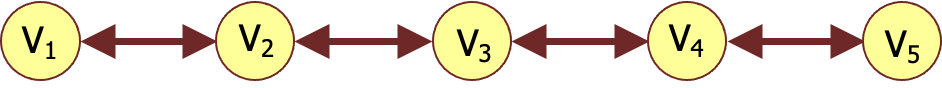

Consider that agent $1$ is assigned to be the leader of the formation, and suppose that its goal is to track a given referense trajectory $x_d(t)$.






We start to impose obstacle avoidance for the leader as follows 

$$
u_1 = - K_1 (x_1-x_d) + \frac{k_{1o}(d_1)}{d_1^2} ( x_1 - x_o ) + \dot{x}_d
$$
where
$$
k_{1o}(d) = \bar k_{1o}e^{-c d_1^2}, \quad d_1 = ||x_1 - x_o ||-r,
$$
$x_o$ and $r$ are the center position of the obstacle and radius, respectively, and $k_{1o}, c$ are positive gains.





For the other agents, we have to add the repulsive terms to avoid collision between the agents and the obstacle. In this case , we obtain 

$$
u_i = - K_i \sum_{j\in N_i}\big((x_i-x_j) -b_{ij}\big) + \sum_{j= 1}^n \frac{k_{ij}(d_{ij})}{d_{ij}^2} ( x_i - x_j )+ \frac{k_{io}(d_i)}{d_{io}^2} ( x_1 - x_o ) +
\dot x_d, \quad i=2, 3,\ldots n
$$

$$
d_{ij} = ||x_i - x_j ||, \quad
d_{io} = ||x_i - x_o ||-r
$$


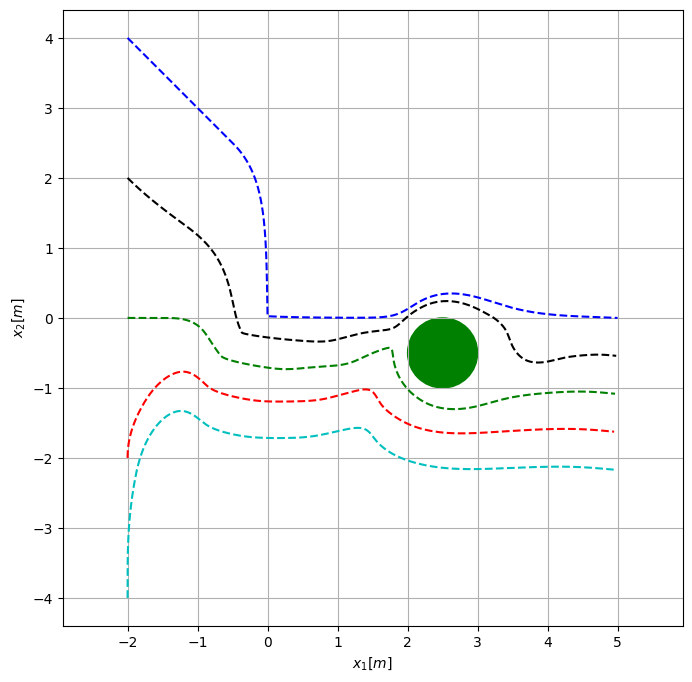

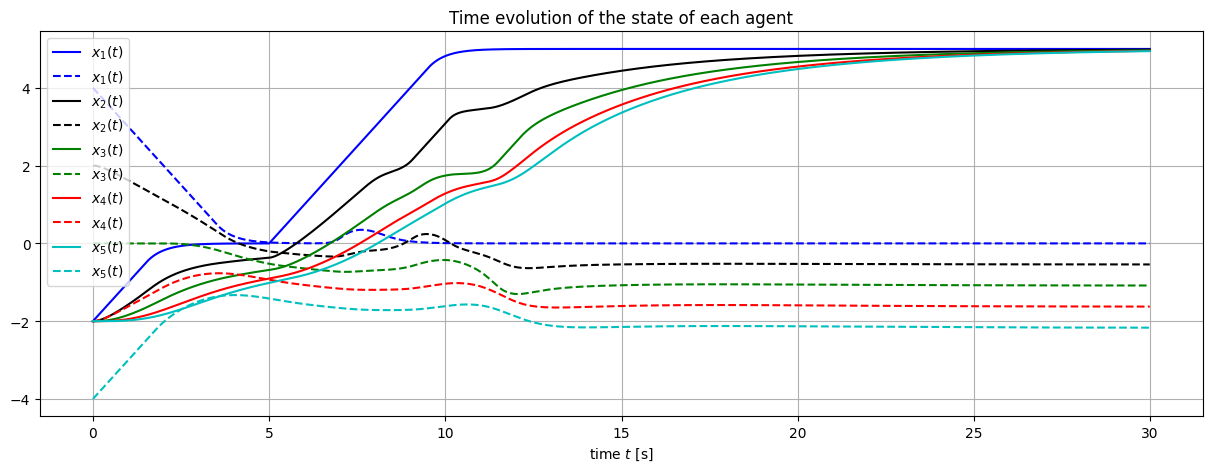

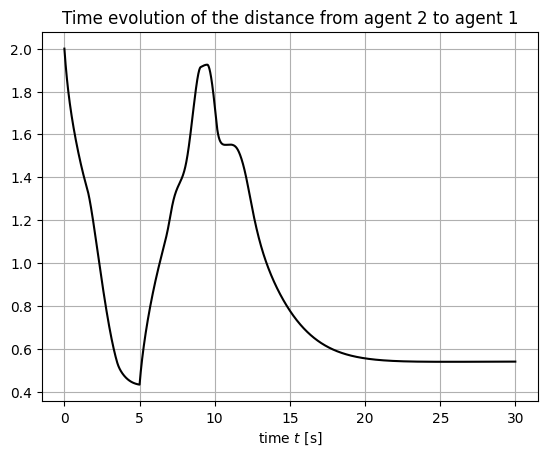

In [49]:
import numpy as np
import matplotlib.pyplot as plt


def step_f(x,u,h):
  return x + u*h

h = 0.01 # This is my sampling time
t_end=30 # This is my final time of the simulation

t_signal = np.arange(0,t_end,h) # time samples

x1_signal = np.zeros_like([t_signal,t_signal])
u1_signal = np.zeros_like([t_signal,t_signal])
x2_signal = np.zeros_like([t_signal,t_signal])
u2_signal = np.zeros_like([t_signal,t_signal])
x3_signal = np.zeros_like([t_signal,t_signal])
u3_signal = np.zeros_like([t_signal,t_signal])
x4_signal = np.zeros_like([t_signal,t_signal])
u4_signal = np.zeros_like([t_signal,t_signal])
x5_signal = np.zeros_like([t_signal,t_signal])
u5_signal = np.zeros_like([t_signal,t_signal])

xd_signal= np.zeros_like(x1_signal)
xd_dot_signal= np.zeros_like(x1_signal)


#Initial conditions of each agent
x1_signal[:,0] = [-2.0, 4.0]
x2_signal[:,0] = [-2.0, 2.0]
x3_signal[:,0] = [-2.0, 0.0]
x4_signal[:,0] = [-2.0, -2.0]
x5_signal[:,0] = [-2.0, -4.0]

# control parameters
kx, ky = 2, 2
K = np.diag([kx,ky])

K1o_init = 0.1*K
c = 5
xo = np.array([ 2.5, -0.5 ])
radius = 0.5

K2o_init = 0.1*K
K2j_init = 0.1*K
K3o_init = 0.1*K
K3j_init = 0.1*K
K4o_init = 0.1*K
K4j_init = 0.1*K
K5o_init = 0.1*K
K5j_init = 0.1*K

b12 = [0.0, 0.5]
b23 = [0.0, 0.5]
b34 = [0.0, 0.5]
b45 = [0.0, 0.5]

# Iteration
for i in range(0,t_signal.shape[0]-1):
  # desired signal
  xd_signal[:,i] = 5*np.array([ np.heaviside(t_signal[i]-5,1.0), 0 ])
# The following is just to simplify the notation
  xd = xd_signal[:,i]
  xd_dot = xd_dot_signal[:,i]
  x1 = x1_signal[:,i]
  x2 = x2_signal[:,i]
  x3 = x3_signal[:,i]
  x4 = x4_signal[:,i]
  x5 = x5_signal[:,i]

  # control signals
  d1o = np.linalg.norm(x1 - xo) - radius
  u1_signal[:,i] = -K@(x1-xd) \
  + (1/d1o**2)*K1o_init*np.exp(-c*d1o**2) @ ( x1 - xo ) + xd_dot

  d2o = np.linalg.norm(x2 - xo) - radius    
  d21 = np.linalg.norm(x2 - x1)    
  d23 = np.linalg.norm(x2 - x3)    
  d24 = np.linalg.norm(x2 - x4)    
  d25 = np.linalg.norm(x2 - x5)    
  u2_signal[:,i] = -K@((x2-x1+b12)+(x2-x3)-b23) \
  + (1/d21**2)*K2j_init*np.exp(-c*d21**2) @ ( x2 - x1 ) \
  + (1/d23**2)*K2j_init*np.exp(-c*d23**2) @ ( x2 - x3 ) \
  + (1/d24**2)*K2j_init*np.exp(-c*d24**2) @ ( x2 - x4 ) \
  + (1/d25**2)*K2j_init*np.exp(-c*d25**2) @ ( x2 - x5 ) \
  + (1/d2o**2)*K2o_init*np.exp(-c*d2o**2) @ ( x2 - xo ) + xd_dot


  d3o = np.linalg.norm(x3_signal[:,i] - xo) - radius    
  d31 = np.linalg.norm(x3_signal[:,i] - x1_signal[:,i])    
  d32 = np.linalg.norm(x3_signal[:,i] - x2_signal[:,i])    
  d34 = np.linalg.norm(x3_signal[:,i] - x4_signal[:,i])    
  d35 = np.linalg.norm(x3_signal[:,i] - x5_signal[:,i])    
  u3_signal[:,i] = -K@((x3-x2+b23)+(x3-x4)-b34) \
  + (1/d31**2)*K3j_init*np.exp(-c*d31**2) @ ( x3 - x1 ) \
  + (1/d32**2)*K3j_init*np.exp(-c*d32**2) @ ( x3 - x2 ) \
  + (1/d34**2)*K3j_init*np.exp(-c*d34**2) @ ( x3 - x4 ) \
  + (1/d35**2)*K3j_init*np.exp(-c*d35**2) @ ( x3 - x5 ) \
  + (1/d3o**2)*K3o_init*np.exp(-c*d3o**2) @ ( x3 - xo ) + xd_dot

  d4o = np.linalg.norm(x4_signal[:,i] - xo) - radius
  d41 = np.linalg.norm(x4_signal[:,i] - x1_signal[:,i])
  d42 = np.linalg.norm(x4_signal[:,i] - x2_signal[:,i])
  d43 = np.linalg.norm(x4_signal[:,i] - x3_signal[:,i])
  d45 = np.linalg.norm(x4_signal[:,i] - x5_signal[:,i])
  u4_signal[:,i] = -K@((x4-x3+b34)+(x4-x5)-b45) \
  + (1/d41**2)*K4j_init*np.exp(-c*d41**2) @ ( x4 - x1 ) \
  + (1/d42**2)*K4j_init*np.exp(-c*d42**2) @ ( x4 - x2 ) \
  + (1/d43**2)*K4j_init*np.exp(-c*d43**2) @ ( x4 - x3 ) \
  + (1/d45**2)*K4j_init*np.exp(-c*d45**2) @ ( x4 - x5 ) \
  + (1/d4o**2)*K4o_init*np.exp(-c*d4o**2) @ ( x4 - xo ) + xd_dot

  d5o = np.linalg.norm(x5_signal[:,i] - xo) - radius
  d51 = np.linalg.norm(x5_signal[:,i] - x1_signal[:,i])
  d52 = np.linalg.norm(x5_signal[:,i] - x2_signal[:,i])
  d53 = np.linalg.norm(x5_signal[:,i] - x3_signal[:,i])
  d54 = np.linalg.norm(x5_signal[:,i] - x4_signal[:,i])
  u5_signal[:,i] = -K@(x5-x4+b45) \
  + (1/d51**2)*K5j_init*np.exp(-c*d51**2) @ ( x5 - x1 ) \
  + (1/d52**2)*K5j_init*np.exp(-c*d52**2) @ ( x5 - x2 ) \
  + (1/d53**2)*K5j_init*np.exp(-c*d53**2) @ ( x5 - x3 ) \
  + (1/d54**2)*K5j_init*np.exp(-c*d54**2) @ ( x5 - x4 ) \
  + (1/d5o**2)*K5o_init*np.exp(-c*d5o**2) @ ( x5 - xo ) + xd_dot
  
  
  # clip 
  u1_signal[:,i] = np.clip(u1_signal[:,i], -1, 1)
  u2_signal[:,i] = np.clip(u2_signal[:,i], -1, 1)
  u3_signal[:,i] = np.clip(u3_signal[:,i], -1, 1)
  u4_signal[:,i] = np.clip(u4_signal[:,i], -1, 1)
  u5_signal[:,i] = np.clip(u5_signal[:,i], -1, 1)

  # update/send the actuation signals
  x1_signal[:,i+1] = step_f(x1_signal[:,i],u1_signal[:,i],h)
  x2_signal[:,i+1] = step_f(x2_signal[:,i],u2_signal[:,i],h)
  x3_signal[:,i+1] = step_f(x3_signal[:,i],u3_signal[:,i],h)
  x4_signal[:,i+1] = step_f(x4_signal[:,i],u4_signal[:,i],h)
  x5_signal[:,i+1] = step_f(x5_signal[:,i],u5_signal[:,i],h)


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot();
ax.plot(x1_signal[0], x1_signal[1], label='$x_1(t)$', color='b', linestyle='dashed')
ax.plot(x2_signal[0], x2_signal[1], label='$x_2(t)$', color='k', linestyle='dashed')
ax.plot(x3_signal[0], x3_signal[1], label='$x_3(t)$', color='g', linestyle='dashed')
ax.plot(x4_signal[0], x4_signal[1], label='$x_4(t)$', color='r', linestyle='dashed')
ax.plot(x5_signal[0], x5_signal[1], label='$x_5(t)$', color='c', linestyle='dashed')
circle = plt.Circle(xo, radius, color='g', label='obstacle')
ax.add_patch(circle);
ax.axis('equal');
ax.set_xlabel('$x_1 [m]$');
ax.set_ylabel('$x_2 [m]$');
ax.grid();


plt.figure(figsize=(15,5))
plt.plot(t_signal, x1_signal[0], label='$x_1(t)$', color='b')
plt.plot(t_signal, x1_signal[1], label='$x_1(t)$', color='b', linestyle='dashed')
plt.plot(t_signal, x2_signal[0], label='$x_2(t)$', color='k')
plt.plot(t_signal, x2_signal[1], label='$x_2(t)$', color='k', linestyle='dashed')
plt.plot(t_signal, x3_signal[0], label='$x_3(t)$', color='g')
plt.plot(t_signal, x3_signal[1], label='$x_3(t)$', color='g', linestyle='dashed')
plt.plot(t_signal, x4_signal[0], label='$x_4(t)$', color='r')
plt.plot(t_signal, x4_signal[1], label='$x_4(t)$', color='r', linestyle='dashed')
plt.plot(t_signal, x5_signal[0], label='$x_5(t)$', color='c')
plt.plot(t_signal, x5_signal[1], label='$x_5(t)$', color='c', linestyle='dashed')
plt.xlabel('time $t$ [s]');
plt.legend(loc='best')
plt.grid()
plt.title('Time evolution of the state of each agent');

plt.figure()
x1=x1_signal[0]
y1=x1_signal[1]
x2=x2_signal[0]
y2=x2_signal[1]
xi21=zip(x1,y1,x2,y2)
xi21 = [np.sqrt((x1-x2)**2+(y1-y2)**2) for (x1,y1,x2,y2) in xi21]
plt.plot(t_signal, xi21, label='$x_1-x_2$', color='k')
plt.grid()
plt.title('Time evolution of the distance from agent 2 to agent 1');
plt.xlabel('time $t$ [s]');

Let's make a movie!

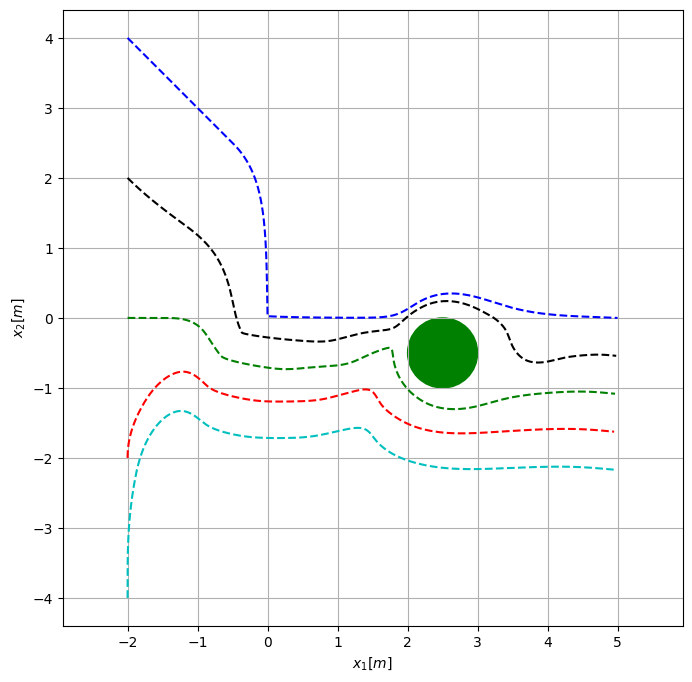

In [50]:
fig1 = plt.figure(figsize=(8,8))
ax3 = fig1.add_subplot();
ax3.plot(x1_signal[0], x1_signal[1], label='$x_1(t)$', color='b', linestyle='dashed')
ax3.plot(x2_signal[0], x2_signal[1], label='$x_2(t)$', color='k', linestyle='dashed')
ax3.plot(x3_signal[0], x3_signal[1], label='$x_3(t)$', color='g', linestyle='dashed')
ax3.plot(x4_signal[0], x4_signal[1], label='$x_4(t)$', color='r', linestyle='dashed')
ax3.plot(x5_signal[0], x5_signal[1], label='$x_5(t)$', color='c', linestyle='dashed')

circle = plt.Circle(xo, radius, color='g', label='obstacle')
ax3.add_patch(circle);

ax3.axis('equal');
ax3.set_xlabel('$x_1 [m]$');
ax3.set_ylabel('$x_2 [m]$');
ax3.grid();


In [51]:
txt_title = ax3.set_title('')
pt1, = ax3.plot([], [], 'b.', ms=20)
line1, = ax3.plot([], [], 'b', lw=2)
pt2, = ax3.plot([], [], 'k.', ms=20)
line2, = ax3.plot([], [], 'k', lw=2)
pt3, = ax3.plot([], [], 'g.', ms=20)
line3, = ax3.plot([], [], 'g', lw=2)
pt4, = ax3.plot([], [], 'r.', ms=20)
line4, = ax3.plot([], [], 'r', lw=2)
pt5, = ax3.plot([], [], 'c.', ms=20)
line5, = ax3.plot([], [], 'c', lw=2)

def drawframe(n):
    size_x = len(x1_signal[0])
    frames = 100
    t_win = int(size_x/frames*(n+1)-1)
    line1.set_data(x1_signal[0, 0:t_win],x1_signal[1, 0:t_win])  
    pt1.set_data(x1_signal[0, t_win],x1_signal[1, t_win])  
    line2.set_data(x2_signal[0, 0:t_win],x2_signal[1, 0:t_win])  
    pt2.set_data(x2_signal[0, t_win],x2_signal[1, t_win])  
    line3.set_data(x3_signal[0, 0:t_win],x3_signal[1, 0:t_win])  
    pt3.set_data(x3_signal[0, t_win],x3_signal[1, t_win])  
    line4.set_data(x4_signal[0, 0:t_win],x4_signal[1, 0:t_win])  
    pt4.set_data(x4_signal[0, t_win],x4_signal[1, t_win])  
    line5.set_data(x5_signal[0, 0:t_win],x5_signal[1, 0:t_win])  
    pt5.set_data(x5_signal[0, t_win],x5_signal[1, t_win])  
    
    txt_title.set_text('Frame = {0:4d}'.format(n))
    return (pt1, line1) #(line1,line2)


from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig1, drawframe, frames=100, interval=50, blit=True)




from IPython.display import HTML
HTML(anim.to_html5_video())

**Activity 2.** Go above and try:

1.   Other (positive) values for the gains
2.   Different initial conditions $x_i(0)$
3. Different reference signals $x_d(t)$
4. More than one obstacle


**Activity 3.** Suppose now that your control signals (that is the velocities of the agents) can only take values between $[-1, 1]$. Go above and limit to that values by including saturations (e.g., for $u_1$ just do *u_control1 = np.clip(u_control1, -1, 1)*